In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_ei_basic
from bo_functions import ExactGPModel
from bo_functions import calc_GP_outputs
from bo_functions import train_GP_model

from bo_plotters import plot_hyperparams
from bo_plotters import y_plotter_basic
from bo_plotters import stdev_plotter_basic
from bo_plotters import ei_plotter_basic

In [2]:
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])

In [4]:
#Define GP Testing space
#Define Testing Space
p=10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta_space = torch.tensor(theta_mesh.T.reshape(-1, 2)) #25 x 2
# print(test_T)

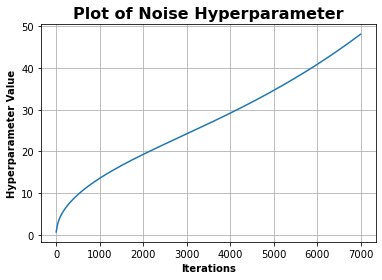

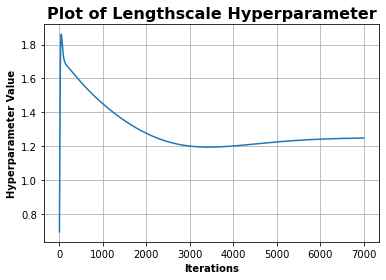

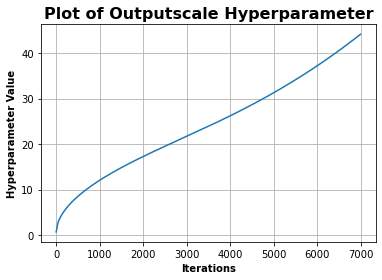

The GP predicts that Theta1 = 0.22222222222222232 and Theta2 = -0.6666666666666667
The point that should be sampled next is Theta1 = -1.1111111111111112 and Theta2 = 2.0


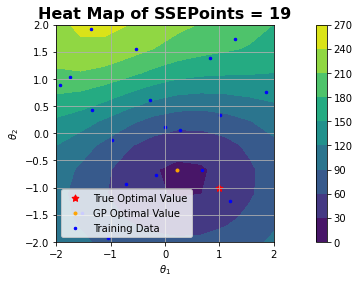

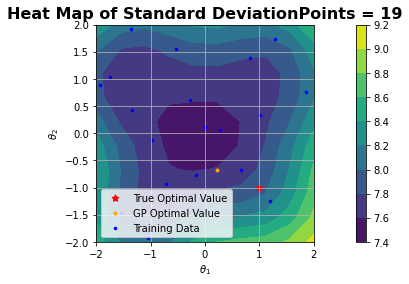

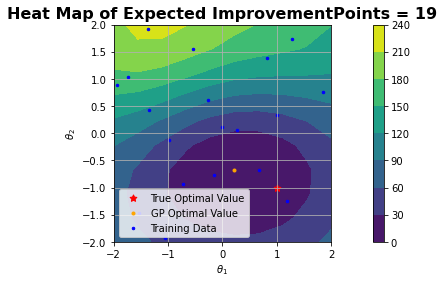

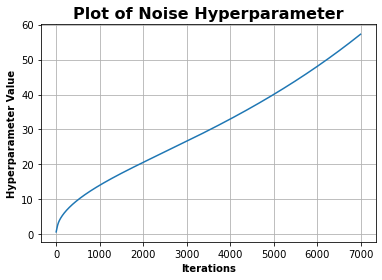

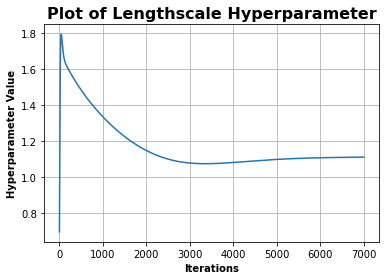

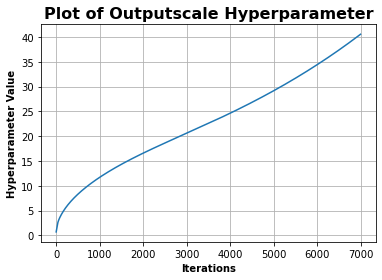

The GP predicts that Theta1 = 0.22222222222222232 and Theta2 = -0.6666666666666667
The point that should be sampled next is Theta1 = -1.5555555555555556 and Theta2 = 1.5555555555555554


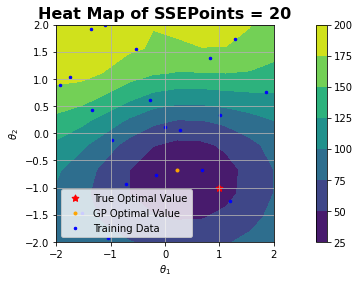

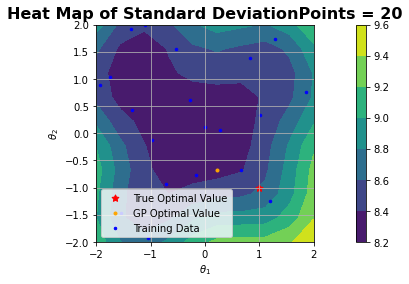

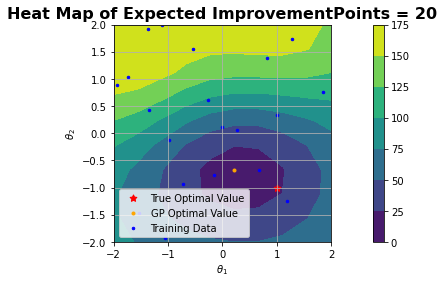

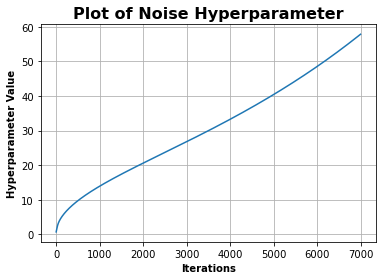

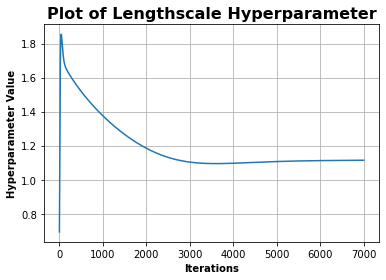

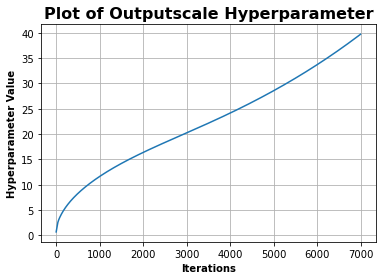

The GP predicts that Theta1 = 0.22222222222222232 and Theta2 = -0.6666666666666667
The point that should be sampled next is Theta1 = 0.6666666666666665 and Theta2 = 2.0


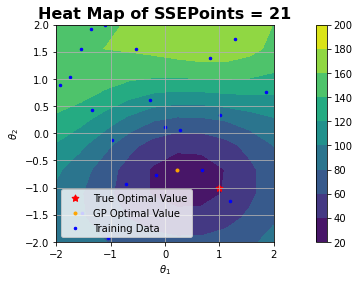

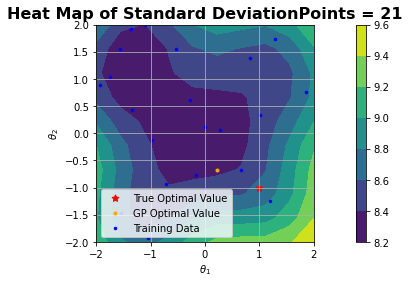

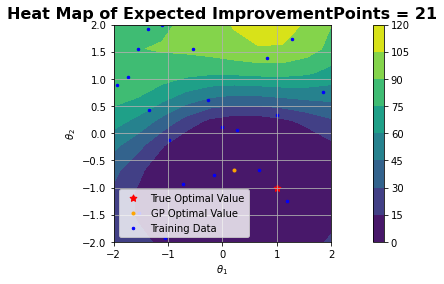

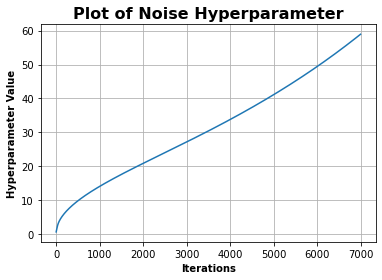

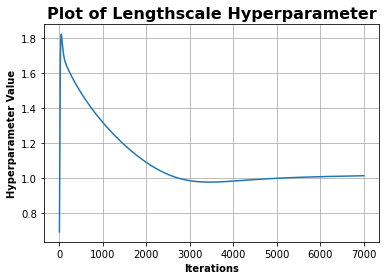

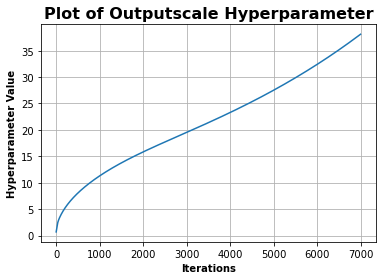

The GP predicts that Theta1 = 0.22222222222222232 and Theta2 = -0.6666666666666667
The point that should be sampled next is Theta1 = -1.1111111111111112 and Theta2 = 1.5555555555555554


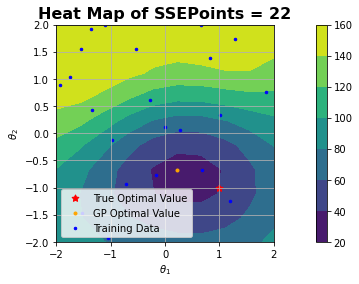

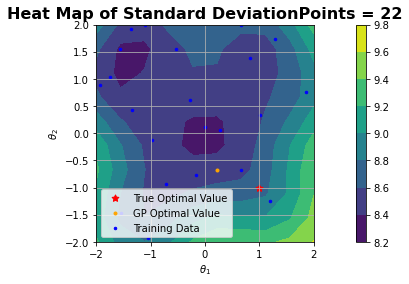

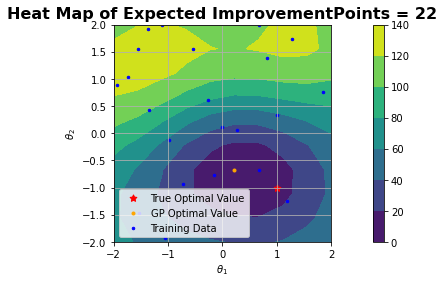

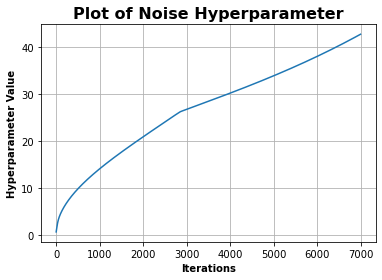

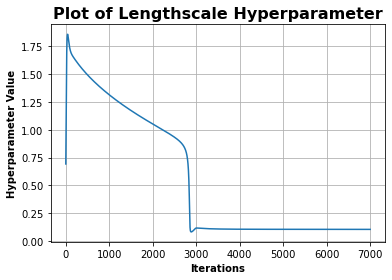

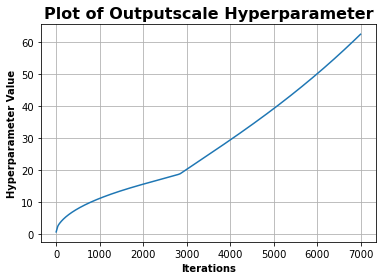

The GP predicts that Theta1 = 0.6666666666666665 and Theta2 = -0.6666666666666667
The point that should be sampled next is Theta1 = -0.6666666666666667 and Theta2 = 1.5555555555555554


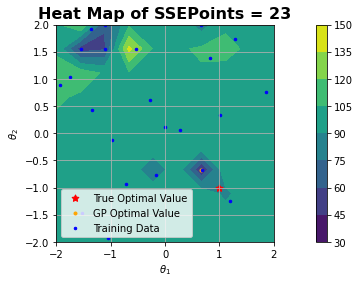

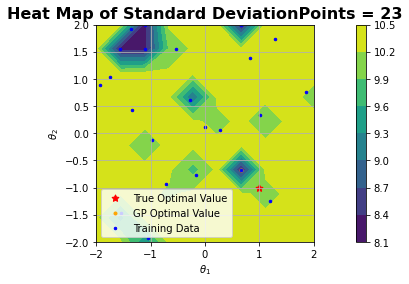

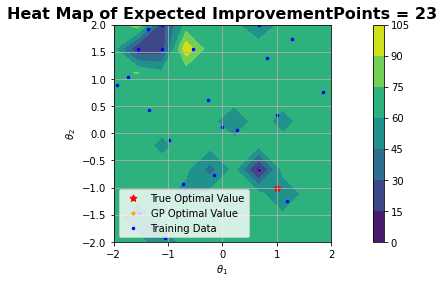

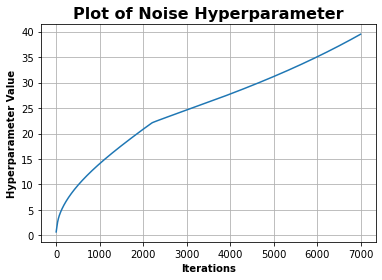

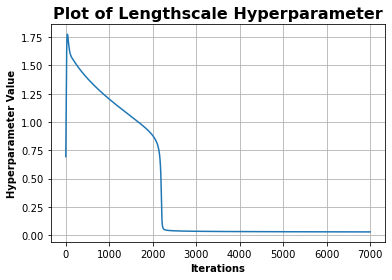

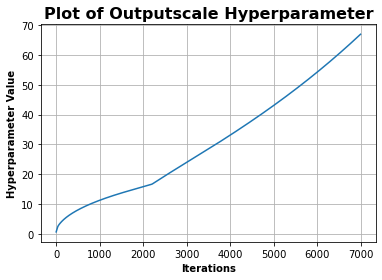

The GP predicts that Theta1 = 0.6666666666666665 and Theta2 = -0.6666666666666667
The point that should be sampled next is Theta1 = -0.22222222222222232 and Theta2 = 0.6666666666666665


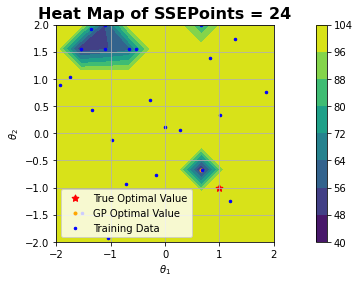

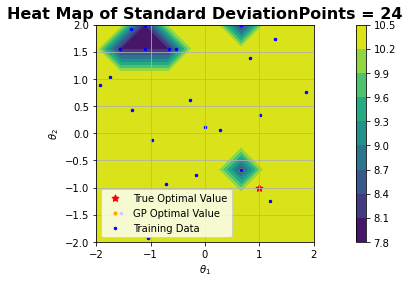

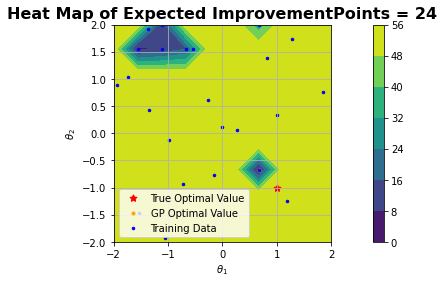

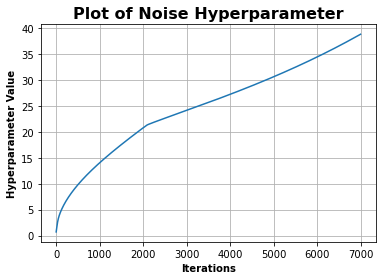

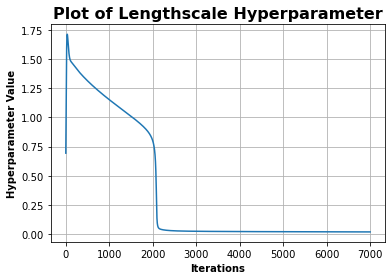

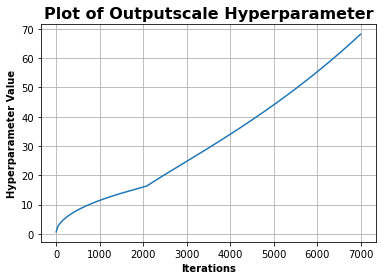

The GP predicts that Theta1 = -1.5555555555555556 and Theta2 = 1.5555555555555554
The point that should be sampled next is Theta1 = -2.0 and Theta2 = -2.0


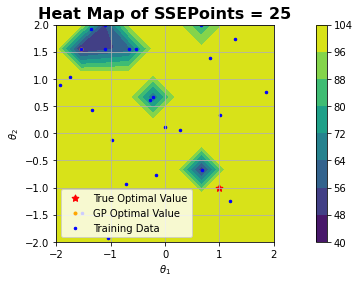

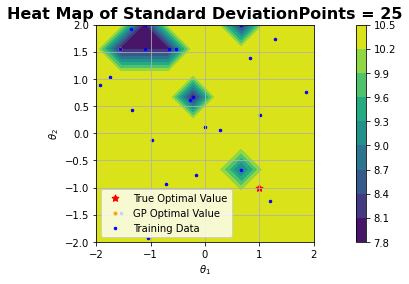

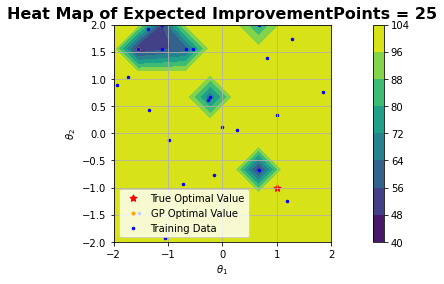

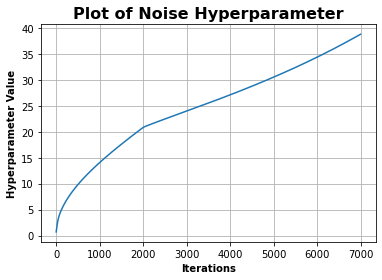

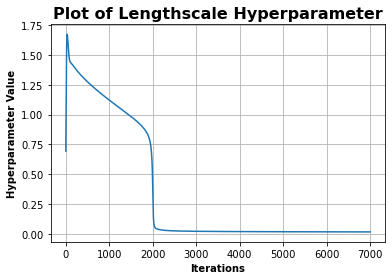

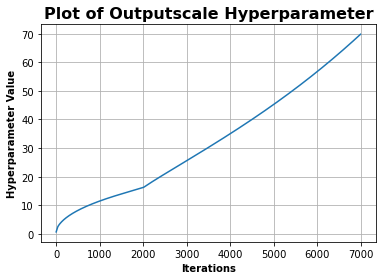

The GP predicts that Theta1 = -2.0 and Theta2 = -2.0
The point that should be sampled next is Theta1 = -2.0 and Theta2 = -1.5555555555555556


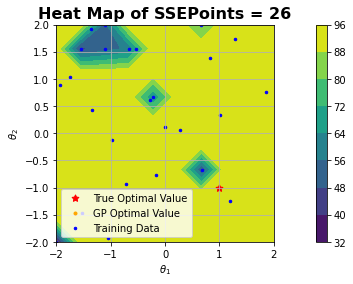

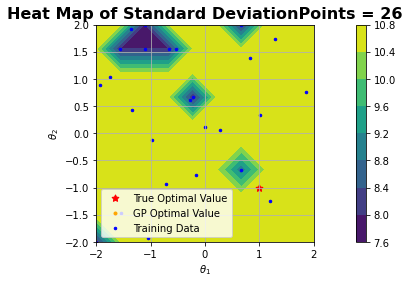

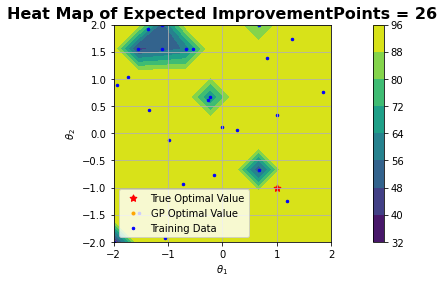

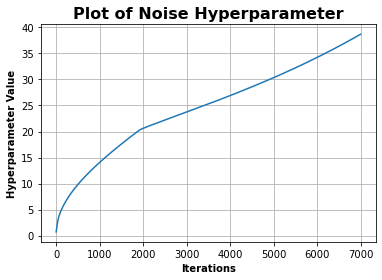

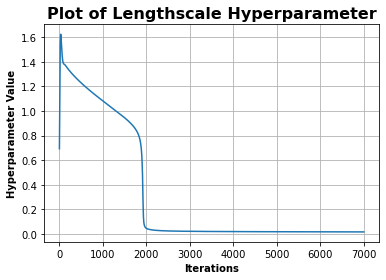

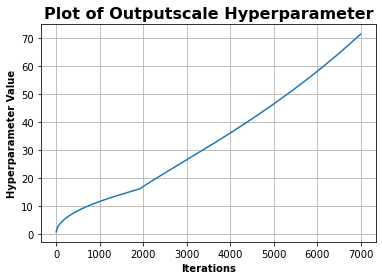

The GP predicts that Theta1 = -2.0 and Theta2 = -2.0
The point that should be sampled next is Theta1 = -2.0 and Theta2 = -1.1111111111111112


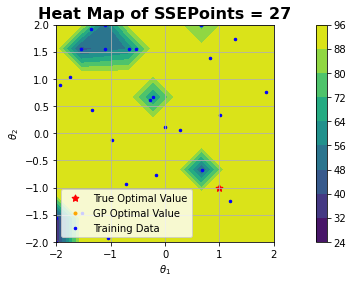

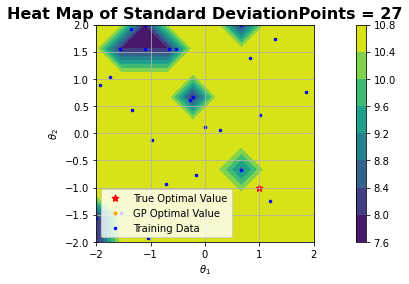

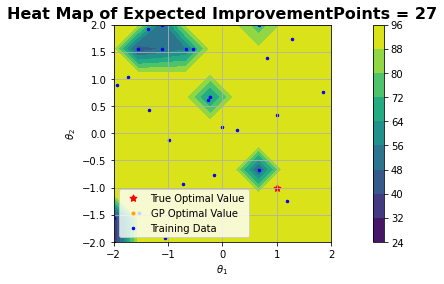

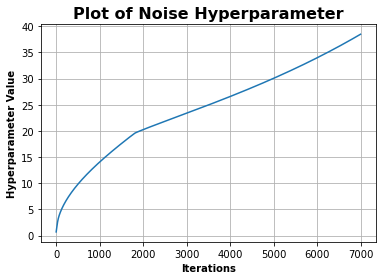

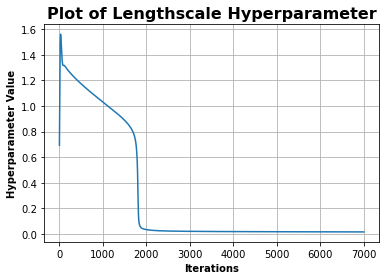

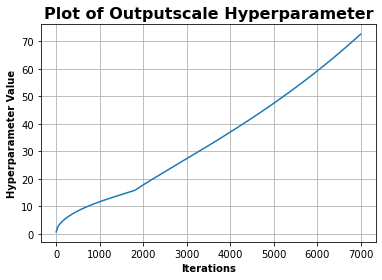

The GP predicts that Theta1 = -2.0 and Theta2 = -2.0
The point that should be sampled next is Theta1 = -2.0 and Theta2 = -0.6666666666666667


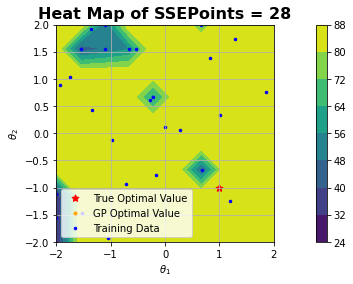

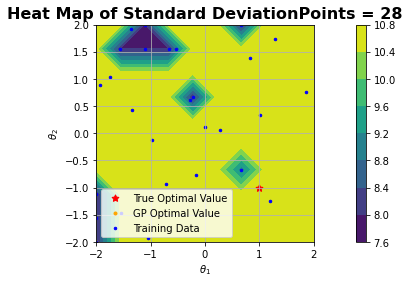

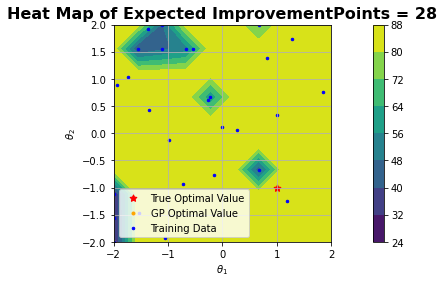

In [5]:
#Training the GP Model
iterations = 7000
BO_iter =12
for i in range(BO_iter):
    if torch.is_tensor(train_T) != True:
        train_T = torch.from_numpy(train_T)
    if torch.is_tensor(train_sse) != True:
        train_sse = torch.from_numpy(train_sse)
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse, likelihood)
    train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
    noise_list = train_GP[0]
    lengthscale_list = train_GP[1]
    outputscale_list = train_GP[2]
    
    #Plot hyperparameters vs iteration
    noise_title = "Noise Hyperparameter"
    lengthscale_title = "Lengthscale Hyperparameter"
    outputscale_title = "Outputscale Hyperparameter"
    plot_hyperparams(iterations, noise_list,noise_title)
    plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
    plot_hyperparams(iterations, outputscale_list,outputscale_title)
    
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    GP_Output = calc_GP_outputs(model, likelihood, theta_space)

    model_mean = GP_Output[0]
    model_variance = GP_Output[1]
    model_stdev = GP_Output[2]
    model_sse = GP_Output[3]

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    Theta_Opt_GP = theta_space[np.argmin(model_sse)].numpy() #1x2
    print("The GP predicts that Theta1 =",Theta_Opt_GP[0],"and Theta2 =", Theta_Opt_GP[1])

    #calculates best_error and expected improvement
    best_error = np.argmax(model_sse)
    ei = calc_ei_basic(best_error,model_mean,model_variance)
    #Calculate Theta value that yields highest EI
    Theta_Best_Ei = theta_space[np.argmax(ei)].numpy()
    print("The point that should be sampled next is Theta1 =",Theta_Best_Ei[0],"and Theta2 =", Theta_Best_Ei[1])
    #Formats ei points into a suitable graphing form    
    ei_map = ei.reshape(len(Theta1),-1) # 5x5
    #Formats sse data points into a suitable graphing form    
    sse_map = model_sse.reshape(len(Theta1),-1) #5 x 5
    #Formats stdev data points into suitable graphing form
    stdev_map = model_stdev.reshape(len(Theta1),-1) #5 x 5
    # print(stdev_map)
    
    #Make Plots
    sse_title = "SSE"
    Theta_True = np.array([1,-1])
    y_plotter_basic(theta_mesh, sse_map, Theta_True, Theta_Opt_GP, train_T,sse_title,plot_train=True)
    
    stdev_plotter_basic(theta_mesh, stdev_map,Theta_True, Theta_Opt_GP,train_T,plot_train=True)
    ei_plotter_basic(theta_mesh, ei_map, Theta_True, Theta_Opt_GP,train_T,plot_train=True)
    
    #Add Best values to training data   
    train_T = train_T.numpy()
    train_T = np.concatenate((train_T, [Theta_Best_Ei]), axis=0)
    
    train_sse = train_sse.numpy()
    train_sse = np.concatenate((train_sse,[np.argmax(ei)]),axis=0)
    
#     print(train_T)
#         train_sse = torch.tensor(train_sse)